# 030 Introducing NumPy

> COM6018

*Copyright &copy; 2023 Jon Barker, University of Sheffield. All rights reserved*.



In this lab class we are going to use NumPy to analyse the atmospheric gas concentration data that we saw in the previous lab. We will start out by performing some simple tasks without using NumPy, and then we will see how NumPy can make our lives easier.

## Step 1 - Reading the data

Use ideas from the previous lab class to read the file `data/co2e.csv` into a variable called `co2e_data` that represents the file contents as a list of dictionaries. Make sure that the dictionary entries are of the correct type (i.e., the `year` entry should be an integer, the `co2_concentration` entry should be a float).

Write your solution in the cell below and then run the test cell to check your solution.

In [1]:
# SOLUTION
import csv

def read_csv(filename):
    with open(filename, 'r') as fp:
        reader = csv.DictReader(fp, skipinitialspace=True, delimiter=',')
        data = [row for row in reader]
    return data

def fix_data_types(data, fields):
    for row in data:
        for k in fields:
            row[k] = fields[k](row[k])
    return data

co2e_data = read_csv('data/co2e.csv')
co2e_data = fix_data_types(co2e_data, {'year': int, 'month':int, 'day': int, 'co2_concentration':  float, 'ch4_concentration': float, 'co2e': float, 'decimal_year': float})

In [2]:
# TEST
assert (co2e_data[0]) == {'year': 1987,
 'month': 4,
 'day': 3,
 'co2_concentration': 350.84,
 'ch4_concentration': 1.70002,
 'co2e': 393.34049999999996,
 'decimal_year': 1987.2554794520547}
print('All tests passed!')

All tests passed!


## Step 2 - Extracting the data

We want to analyse the atmospheric gas concentrations as a sequence of values that change over time. The way that the data is currently stored does not make this very easy. We need to extract the data from each field in the list of dictionaries and store it in a more convenient form, such as a list. For example, we would like all of the `co2_concentration` values to be stored in a list called `co2_concentrations`.

Write a function called `extract_data` that takes the list of dictionaries and a field name as input and returns a list of values for that field. For example, `extract_data(co2e_data, 'co2_concentration')` should return a list of CO<sub>2</sub> concentrations. 

In [3]:
# SOLUTION

def extract_data(data, field):
    return [entry[field] for entry in data]


In [4]:
# TEST
co2_concentration = extract_data(co2e_data, 'co2_concentration')
ch4_concentration = extract_data(co2e_data, 'ch4_concentration')
decimal_year = extract_data(co2e_data, 'decimal_year')

assert co2_concentration[0] == 350.84
assert ch4_concentration[0] == 1.70002
print('All tests passed!')

All tests passed!


## Step 3 - Smoothing the data

Before we do anything with the data it is a good idea to visualise it. We can do this using matplotlib. For example, the following code will plot the CO<sub>2</sub> concentrations against time:

```python
import matplotlib.pyplot as plt
plt.plot(decimal_year, co2_concentrations)
```

Copy this into the cell below and run it to see the plot.

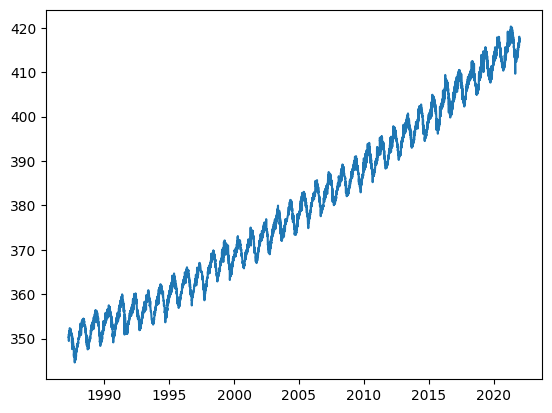

In [5]:
# SOLUTION

import matplotlib.pyplot as plt
plt.plot(decimal_year, co2_concentration)

You should see a graph that trends upwards over time but which also has a season oscillation, i.e., the concentration of CO<sub>2</sub> in the atmosphere increases and decreases over the course of a year. This is because the concentration of CO<sub>2</sub> in the atmosphere is affected by the seasons. In the summer, plants grow and absorb CO<sub>2</sub> from the atmosphere, and in the winter they die and release CO<sub>2</sub> back into the atmosphere.

Let's say that we now want to calculate the date and value of the maximum and minimum CO<sub>2</sub> concentrations, i.e., the peaks and the dips in the graph. One way of finding a peak is to look for a value that is greater than the values either side of it. For example, if we have a list of values `[1, 2, 3, 2, 1]` then the value 3 is a peak because it is greater than the values either side of it. However, if we apply this logic to the data directly we will find that there are many peaks and dips that are not of interest, i.e., if we zoom in on one year we will see that the data is very noisy.

In the cell below, repeat the plot but only using the first 300 elements of `decimal_year` and `co2_concentration`. By looking at just this small segment of the data, you should be able to see these unwanted peaks and dips more clearly.

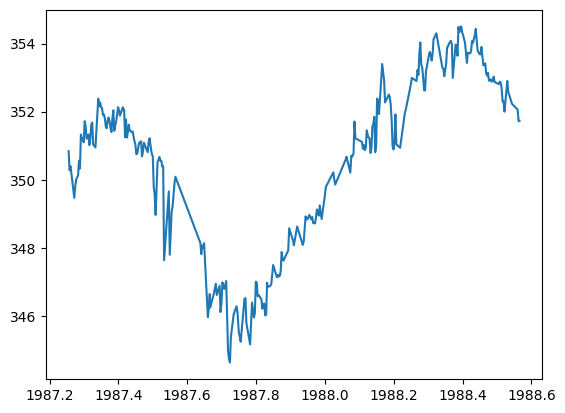

In [6]:
# SOLUTION

plt.plot(decimal_year[0:300], co2_concentration[0:300])

The solution to this is to apply a 'smoothing filter' to the data before we look for the picks and dips. A smoothing filter is a function that takes a list of numbers as input and returns a new list of numbers that are 'smoothed' versions of the input. It does this by sliding a window over the input list and calculating the weighted sum of the numbers in the window. 

For example, say we have a list of numbers `[1, 2, 3, 2, 1, 2, 3, 1]` and we want to apply a smoothing filter with a window size of 3 with the window values `[0.25, 0.5, 0.25]`.  The first smoothed output value will be calculated by takeing the first three numbers `[1, 2, 3]` and computing the weighted sum `0.25*1 + 0.5*2 + 0.25*3 = 2`. We then step foward one place and take the numbers `[2, 3, 2]` and compute the smoothed value as  `0.25*2 + 0.5*3 + 0.25*2 = 2.25`, and so on.

Note, the weights in the window must sum to 1.0. This is because we want the smoothed values to be on the same scale as the input values. If the weights do not sum to one we can simply normalise them by dividing each weight by the sum of the weights.

Write a function called `smooth_series(series, window)` that takes two parameters: series - a list of numbers to smooth, and a window - a list of numbers to use as the weights. Remember to normalise the weights so that they sum to 1.0. The function should return a new list of smoothed values.

Write the function below and then check it by running the test cell.


In [7]:
# SOLUTION
def smooth_series(series, window):
    y = []
    N = len(window)
    window_sum = sum(window)
    for i in range(len(series)-N+1):
        y.append(sum(x*w for x,w in zip(series[i:i+N], window)))
    y = [yi/window_sum for yi in y]
    return y

In [8]:
# TEST
series = [1, 2, 1, 2, 1]
assert smooth_series(series, [1]) == series
assert smooth_series(series, [1, 1]) == [1.5, 1.5, 1.5, 1.5]
print("All tests passed!")

All tests passed!


We will now use the smoothing function to smooth the data. The function allows the window to be of different lengths. The longer the window is, the smoother the data will be. If we make the window too long then we will lose the annual peaks and dips that we are interested in (this is called 'over-smoothing').

Test the smoothing by using window lengths of 7, 60, 360 and plot the result. Store the smoothed data in variables called `co2_concentration_smooth7`, `co2_concentration_smooth_60` and `co2_concentration_smooth360` respectively.  Plot the smoothed data on the same graph as the original data so that you can compare them.

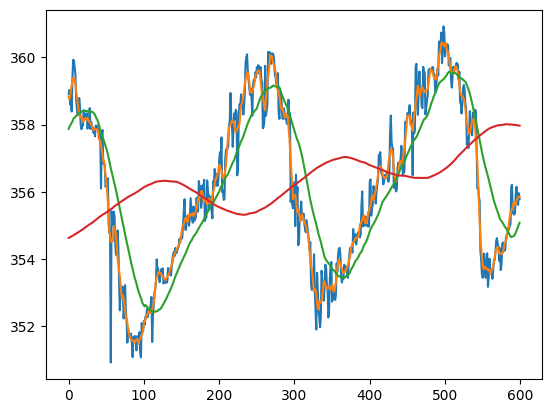

In [12]:
# SOLUTION
import matplotlib.pyplot as plt

co2_concentration_smooth7 = smooth_series(co2_concentration, [1] * 7)
co2_concentration_smooth60 = smooth_series(co2_concentration, [1] * 60)
co2_concentration_smooth360 = smooth_series(co2_concentration, [1] * 360)

plt.plot(co2_concentration[1000:1600])
plt.plot(co2_concentration_smooth7[1000-3:1600-3])
plt.plot(co2_concentration_smooth60[1000-30:1600-30])
plt.plot(co2_concentration_smooth360[1000-180:1600-180])
plt.show()

You should observe that the using a window of 7 is too short and the peaks and dips are still very noisy.  A window of 360 is too long and the peaks and dips are no longer correct. The window of 60 is about right.

## Step 4 - Finding the peaks

We will now locate the peaks and dips in the smoothed data. We will look for peaks by looking for values that are greater than the values either side of them. We can also call these 'local maxima'. We will write a function that take a list of values and compares each value to its neighbours. If the value is greater than both of its neighbours then it is a peak and we will add the value to a list of peaks. We will also record the index of the peak in a list of peak indices. The function will return the list of peaks and the list of peak indices.

Write a function called `find_peaks` that takes a list of values as input and returns a list of peak values and a list of peak indices. Test your function by running the test cell.

In [14]:
# SOLUTION

def find_peaks(series):
    peaks = []
    indices = []
    for i in range(1, len(series)-1):
        if series[i-1] < series[i] and series[i] > series[i+1]:
            peaks.append(series[i])
            indices.append(i)
    return peaks, indices

In [15]:
# TEST
peaks, indices = find_peaks([1,2,1,1,1,2,1,1,2,1])
assert len(peaks) == 3
assert len(indices) == 3
assert indices == [1, 5, 8]
print("All tests passed!")

All tests passed!


Now, in the cell below, run the `find_peaks` function on the smoothed CO<sub>2</sub> concentration data. How many peaks are there? Does there seem to be about one per year (remember, the data spans a 35 year period). Are the indices of the peaks regularly spaced by about 365 days?



In [16]:
# SOLUTION

peaks, indices = find_peaks(co2_concentration_smooth60)
print(len(indices))
print(indices)

168
[9, 94, 221, 223, 231, 316, 319, 468, 475, 480, 559, 705, 713, 717, 725, 815, 976, 979, 983, 986, 1057, 1220, 1227, 1233, 1319, 1461, 1466, 1669, 1673, 1862, 1924, 1933, 2021, 2165, 2177, 2251, 2351, 2354, 2417, 2555, 2560, 2568, 2571, 2575, 2646, 2735, 2769, 2802, 2807, 2810, 2909, 3067, 3151, 3272, 3275, 3450, 3455, 3612, 3688, 3694, 3705, 3780, 3783, 3865, 3931, 3933, 3941, 4103, 4105, 4112, 4117, 4124, 4140, 4418, 4421, 4429, 4708, 4712, 4806, 4815, 4945, 4954, 4993, 5001, 5003, 5009, 5012, 5085, 5102, 5278, 5281, 5293, 5301, 5400, 5404, 5504, 5592, 5594, 5596, 5709, 5828, 5851, 5898, 5904, 5907, 5915, 5920, 5925, 5930, 5936, 6030, 6156, 6218, 6222, 6226, 6521, 6527, 6534, 6540, 6652, 6654, 6764, 6839, 6851, 6859, 6939, 6947, 7131, 7137, 7152, 7247, 7261, 7268, 7341, 7479, 7594, 7598, 7726, 7801, 7815, 7817, 7834, 7937, 7948, 8069, 8160, 8167, 8179, 8279, 8283, 8392, 8418, 8475, 8488, 8495, 8502, 8613, 8808, 8810, 8815, 8932, 9081, 9134, 9139, 9141, 9146, 9148, 9243]


You'll find that there are still too many peaks because the data smoothing is not perfect. Rather then increasing the smoothing window length, we can fix things by using a more robust definition of 'peak'. We will say that a peak needs to be larger than all surrounding values up to a distance of 2 steps away (i.e., the 3 in 1, 2, 3, 2, 1 would be a peak but the 3 in 4, 2, 3, 2, 1 would not).

Implement this new definition of peak in a function called `find_peaks2` and test it by running the test cell.

In [17]:
# SOLUTION

def find_peaks2(series):
    peaks = []
    indices = []
    for i in range(3, len(series)-3):
        if series[i-1] < series[i] and series[i] > series[i+1] and series[i] > series[i-2] and series[i] > series[i+2] and series[i] > series[i-3] and series[i] > series[i+3]:
            peaks.append(series[i])
            indices.append(i)
    return peaks, indices

In [18]:
# TEST

peaks, indices = find_peaks2(co2_concentration_smooth60)
print(len(indices))
print(indices)

77
[9, 221, 468, 475, 480, 713, 725, 976, 1227, 1461, 1466, 1669, 1933, 2165, 2177, 2251, 2351, 2555, 2560, 2568, 2575, 2807, 3067, 3151, 3272, 3455, 3694, 3705, 3780, 3865, 4103, 4112, 4117, 4124, 4421, 4712, 4815, 4945, 5009, 5281, 5301, 5404, 5596, 5851, 5898, 5920, 5925, 5930, 5936, 6030, 6218, 6222, 6540, 6652, 6764, 6851, 7131, 7137, 7152, 7247, 7479, 7594, 7817, 7834, 7948, 8160, 8167, 8179, 8279, 8418, 8495, 8808, 8815, 9081, 9134, 9141, 9146]


You'll see that there are *still* too many peaks, i.e. more than one per year. We can quickly see what is going on by plotting points at the peak positions overlaid on the original data. Run the cell below to see this.

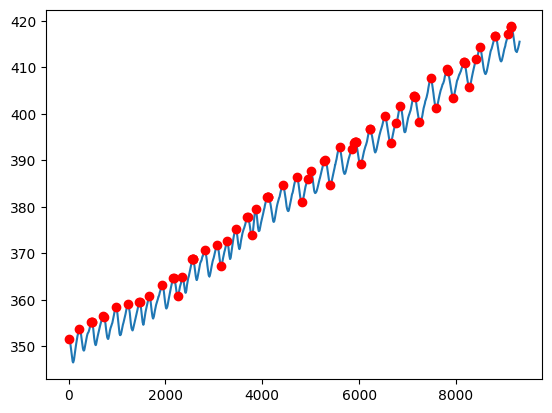

In [19]:
plt.plot(co2_concentration_smooth60)
plt.plot(indices, peaks, 'ro')
plt.show()

Observe the figure above. You should see several problems,

- At least one of the genuine peaks has been missed.
- One peak has been detected twice.
- Strangely, there are many peaks being detected at the location of minima.

Peaks are located at the location of minima because the gradient of the curve is low at the minima, so a small amount of noise can raise a false peak, despite all the smoothing.

This exercise has illustrated how difficult it can be to extract something as simple as a peak from a noisy signal. The peaks are clear to the human eye, but it is difficult to write a program that can detect them reliably. We need more sophisticated statistical modelling approaches if we want to do this robustly.

You'll have also noticed that we've had to write Python code for some very low level operations, such as smoothing and finding peaks. This is a lot of work and it is easy to make mistakes. Also, the code has involved using loops to process the values over the list. This is slow and inefficient. We will now see how NumPy can help us to solve these problems.

## Step 5 - Finding the peaks with NumPy

We will now repeat the exercise above using NumPy. We will start with the original data series `co2_concentration` and `decimal_year`.

Currently, the data is stored as a Python list. To turn them into NumPy arrays we can use the NumPy.array function. For example, the following code will convert the list of `co2_concentration` values into a NumPy array called `co2_concentration_array`.

```python
import numpy as np
co2_concentration = np.array(co2_concentrations)
```

Convert the `co2_concentration` and `decimal_year` lists into NumPy arrays and then plot the `co2_concentration_array` against the `decimal_year_array`. You should see the same graph as before.


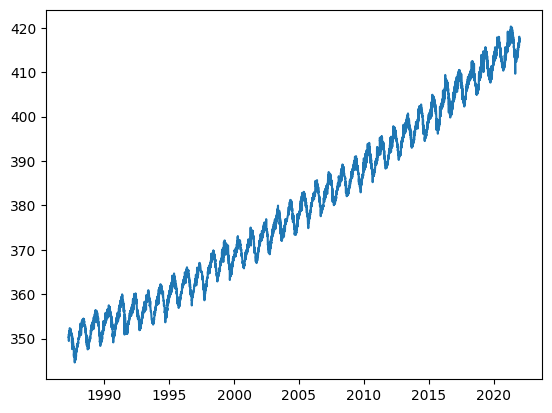

In [20]:
# SOLUTION 

import numpy as np
co2_concentration = np.array(co2_concentration)
decimal_year = np.array(decimal_year)

plt.plot(decimal_year, co2_concentration)

In [21]:
# TEST

assert type(co2_concentration) == np.ndarray
assert type(decimal_year) == np.ndarray
print("All tests passed!")


All tests passed!


We will now rewrite the `smooth_series` function so that it takes the series and window parameters as NumPy arrays. The function should return a NumPy array of smoothed values. The function should work for any window size.

Note, you can use the fact the NumPy allows two vectors to be multiplied together in an elementwise fashion, e.g. x*y will multiply the first element of x by the first element of y, the second element of x by the second element of y, and so on. Also you can make use of the `numpy.sum` function to sum the elements of an array. You will still need to pass the window over the series using a loop and use slicing notation to extract segments of the series to operate on.

In [22]:
# SOLUTION

def smooth_series(series, window):
    N = len(window)
    smoothed = np.array([np.sum(series[i:i+N] * window) for i in range(len(series)-N+1)])
    return smoothed / np.sum(window)


In [23]:
# TEST
series = np.array([1, 2, 1, 2, 1])
assert (smooth_series(series, np.array([1])) == series).all()
assert (smooth_series(series, np.array([1, 1])) == np.array([1.5, 1.5, 1.5, 1.5])).all()
print("All tests passed!")

All tests passed!


The NumPy implementation will have been a little shorter and will run faster. However, we can do much better. The operation of sliding a window over a single and multiplying and summing is know as a 'convolution'. NumPy has a function called `numpy.convolve` that will do this for us. The following code will apply a smoothing window to a series of values:

```python
smoothed = np.convolve(series, window, mode='same')
```

This is actually better than our smoothing function because the `mode='same'` parameter ensures that the function correctly pads the single to make sure the output and input have the same number of elements. 

Try using the convolve function to smooth the `co2_concentration_array` using a window of 90. Store the results in a variable called `co2_concentration_smooth90`. Plot the result and compare it to the previous result. You should see that the results are the same. Note, when plotting, you will need to ignore the first and last 45 samples because the zero padding will mean that these will not have valid values.

Note, you can use the `np.ones` function to make the window array. You will need to divide the window by the sum of the window values to make sure that the weights sum to 1.0 (the `convolve` function does not do this for you).

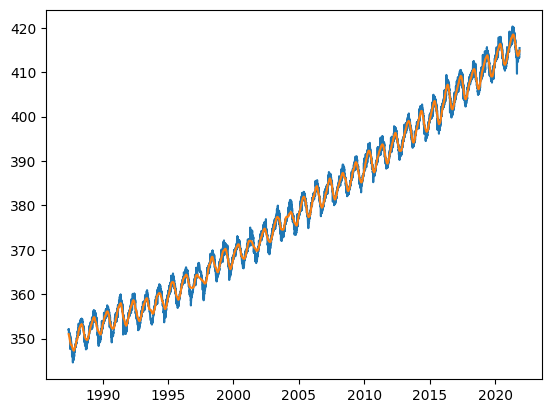

In [24]:
# SOLUTION

co2_concentration_smooth90 = np.convolve(co2_concentration, np.ones(90)/90, mode='same')
plt.plot(decimal_year[45:-45], co2_concentration[45:-45])
plt.plot(decimal_year[45:-45], co2_concentration_smooth90[45:-45])

In [29]:
# TEST
assert co2_concentration.shape == co2_concentration_smooth90.shape


You will have noticed that the smoothed function consistently underestimates the height of the peaks. This is because it is based on an average over 90 days and so the values before and after the peaks pull the average down. You can improve the situation by using a window function that has bigger weights at the centre of the window and which tapers to zero at the edges. There are many window shapes that can be used (e.g., a triangle) but a common on in signal processing is the Hamming window. The values for an N element Hamming window can be produced with NumPy using the following code:

```python
window = np.hamming(N)
```

Try using the `np.convolve` function again but now use `np.hamming` to generate the window. Remember, you will need to divide the window values by their sum so that it sums to 1.0.

Store the new smoothed data in a variable, `co2_concentration_smooth90_h`.

To make the comparison, plot the `co2_concentration` data, and the 90 day smoothed versions using the window of ones, and the Hamming window. To see the difference clearly just look at the first 500 samples of the singles. You should see that the peaks are now better estimated.


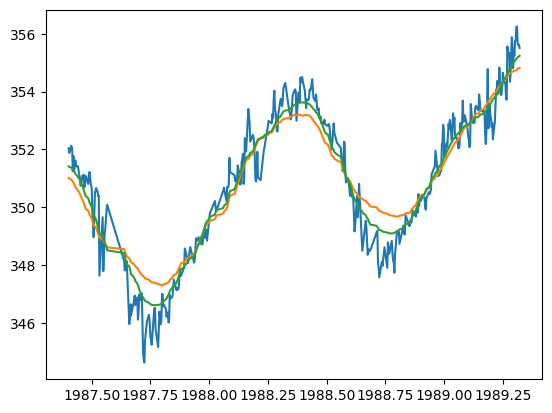

In [30]:
# SOLUTION

co2_concentration_smooth90_h = np.convolve(co2_concentration, np.hamming(90)/np.sum(np.hamming(90)), mode='same')
plt.plot(decimal_year[45:500], co2_concentration[45:500])
plt.plot(decimal_year[45:500], co2_concentration_smooth90[45:500])
plt.plot(decimal_year[45:500], co2_concentration_smooth90_h[45:500])

We will now rewrite the `find_peaks2` function so that it takes a NumPy array as input and returns a NumPy array of peak values and a NumPy array of peak indices.

The function should be implemented without using any for-loops. Instead, you should use NumPy array operations to compare each element of the input array to its neighbours. There are many different ways that this can be done. The approach should be to build an array of logic values that has 'True' at the location of the peaks. You can then use the `numpy.where` function to extract the indices of the peaks and the values of the peaks.

You might find it useful to use the `numpy.roll` function to shift the array by one element. Once the array is shifted you can compare values in the original array to the shifted array. You can also effectively shift the array using slicing notation, e.g. consider the arrays `series[4:]`, `series[3:-1]`, `series[2:-2]`, `series[1:-3]`, `series[:-4]`. These all have the same length but are shifted by different amounts.

You can then use the `numpy.logical_and` function to combine the results of comparisons.

If you are very stuck then seek assistance from a demonstrator.

In [31]:
# SOLUTION

def find_peaks2(series):
    peaks = (series[2:-2] > series[1:-3]) & (series[2:-2] > series[3:-1]) & (series[2:-2] > series[4:]) & (series[2:-2] > series[:-4])
    indices = np.where(peaks == True)[0]
    return series[indices], indices

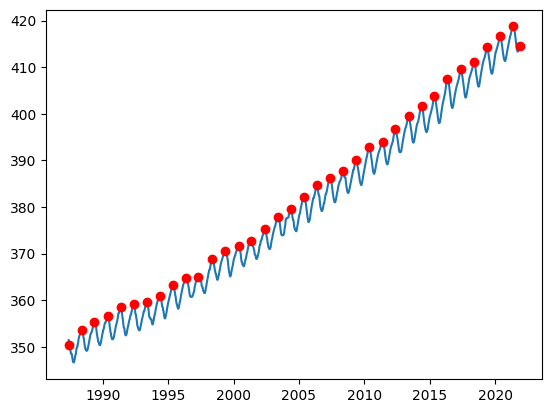

In [32]:
# TEST

peaks, indices = find_peaks2(co2_concentration_smooth90_h)
plt.plot(decimal_year[45:-45],co2_concentration_smooth90_h[45:-45])
plt.plot(decimal_year[indices], peaks, 'ro')
plt.show()

## Step 6 - Computing statistics 

We will now extend the analysis. We will first use write a function to extract the date and value of the dips in the data. We will then compute some statistics on the peaks and dips: the average year-on-year increase in the peak and dip values, and the average time between peaks and dips, the average difference between the peak and dip values.

First, write a function that uses NumPy to find the dips in the data, which you can call find_dips. The function should take a NumPy array as input and return a NumPy array of dip values and a NumPy array of dip indices. It should be very similar to the find_peaks function.

In [33]:
# SOLUTION

def find_dips(series):
    peaks = (series[2:-2] < series[1:-3]) & (series[2:-2] < series[3:-1]) & (series[2:-2] < series[4:]) & (series[2:-2] < series[:-4])
    indices = np.where(peaks == True)[0]
    return series[indices], indices

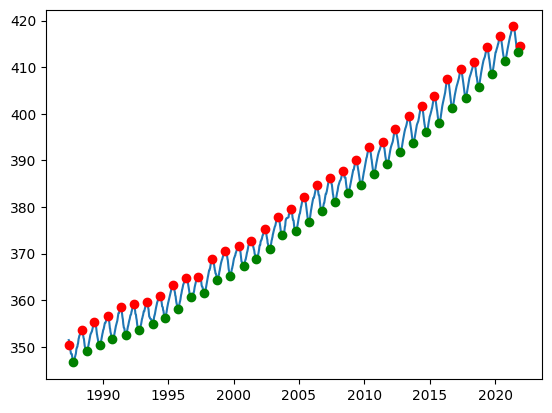

In [34]:
# TEST

dips, dip_indices = find_dips(co2_concentration_smooth90_h)
plt.plot(decimal_year[45:-45],co2_concentration_smooth90_h[45:-45])
plt.plot(decimal_year[indices], peaks, 'ro')
plt.plot(decimal_year[dip_indices], dips, 'go')
plt.show()

Now, we can write a function to compute the average year-on-year increase in the peak and dip values. The function should take a NumPy array of dip or peak values as input and return the average year-on-year increase. (You can assume that your list of dip and peak values has correctly identified the annual peak and dip.)

Call this function compute_average_difference and test it by running the test cell.

In [156]:
def compute_average_difference(series):
    return np.mean(np.diff(series))

In [160]:
# TEST
# Note, first and last values are not included in the average as they are likely to be incorrect
average_peak_difference = compute_average_difference(peaks[1:-1])
average_dip_difference = compute_average_difference(dips[1:-1])
print(average_peak_difference, average_dip_difference)

1.973288592449826 1.9437849206024609


The average increases should be close to 2. i.e. the CO<sub>2</sub> concentration is increasing by about 2 parts per million per year.

Now write short pieces of code to find answers to the following questions

### Q1. What is the average difference between the annual peak and dip values?

In [163]:
# SOLUTION

print(np.mean(peaks[:-1] - dips))

5.0110308986127405


You should have got an answer of about 5 parts per million.

### Q2. What is the average time (in days) between a peak and the next dip?

In [166]:
# SOLUTION

peak_indices = indices
delays = decimal_year[dip_indices[1:]] - decimal_year[peak_indices[1:-1]]
print(np.mean(delays) * 365)

138.49754901965503


You should get an answer of about 140 days.

### Q3. What is the average time (in days) between a dip and the next peak?

In [169]:
# SOLUTION

delays = decimal_year[peak_indices[1:-1]] - decimal_year[dip_indices[:-1]]
print(np.mean(delays) * 365)

226.07843137250313


You should get an answer of about 225 days.

Note that the average peak-to-dip and average dip-to-peak sums to about 365 days, i.e. one year, but the dips are not exactly half way between the peaks. This is because the co2 concentration is increasing over time.



### Q4. On which day of the year on average do the peaks and dips occurs?

To compute this you need to consider just the fractional part of the decimal year value of the peak and dip locations. You can retrieve this using the np.mod function.

```python

In [176]:
# SOLUTION

peak_day = np.mean(np.mod(decimal_year[peak_indices[1:-1]], 1))* 365
dip_day = np.mean(np.mod(decimal_year[dip_indices[1:-1]], 1))* 365
print(peak_day, dip_day)

134.59558823526626 273.4494949495144


I calculate this to be day 135 (peak) and day 273 (dip), i.e., the peaks occur in mid May and the dips occur at the end of September.

If you are interested in the reason for this see

https://keelingcurve.ucsd.edu/2013/06/04/why-does-atmospheric-co2-peak-in-may/

## Summary

This lab class has provided a very short introduction to NumPy covering some basic methods for manipulating simple 1-dimensional data series. Later in the module we will be using it in more mathematical contexts for performing more complex operations involving higher dimensional arrays, e.g. 2-D matrix data. However, we will see that the basic ideas remain the same. We will be leveraging NumPy's ability to perform operations on arrays very efficiently without the need for for-loops. This will allow us to write code that is more concise and easier to understand and which runs much faster than the equivalent code using only native Python data structures and for-loops.